# Perceptron and Adaline

Here I implement the Perceptron and Adaline learning algorithms and train them on the Iris data set. Code is mostly from Sebastian Raschka's Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2.

## Perceptron as an Object

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

Here is whole Perception class, notes on each function follow.

In [2]:
class Perceptron(object):
    
    def __init__(self, eta=.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter=n_iter
        self.random_state=random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state) # Initialize weights to small random values
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size= 1 + X.shape[1])
        self.errors_ = []

        for i in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y): # zip() returns an iterator to a list of tuples (X[1], y[1])
                update = self.eta * (target - self.predict(xi))
                self.w_[0] += update # bias unit is updated separately since it is paired with x0 = 1, not actually in data
                self.w_[1:] += update * xi
                errors += int(update != 0.0)
            self.errors_.append(errors) # Use errors later to analyze performance
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0] # Does (w^T)X dot product
       
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

The init function is the constructor: eta is the learning rate, n_iter is the number of times to iterate over training set, random_state is randon seed so we can repeat exact results. In gradient descent, eta is the step size, or how far away you should jump to get the next x (in the 'steepest way down' direction). Here is seems to scale the significance of an incorrect prediction: A larger learning rate will generate a larger weight update following an incorrect prediction. Eta is usually a value between 0 and 1.

The fit function is where we calculate the weight update based on the actual target value, our prediction, and the learning rate. The weights are initialized as self.w_ - The underscore denotes class variables that are not created in the constructor.

The net_input function calculates the actual value of function/learning model using the current weights and a given X, and then based on that actual float value, the predict function assigns 1 or -1. The predict function will also be used on new data. The predict function is called within the for loop on each X in the training data set to fit the model. Note that it requires the weights to be initialized - I think if you called in on a Perceptron instance before calling fit, you would get an error, since fit initializes the weights. Wouldn't it be better to initialize them in the constructor?

## Testing Perceptron

The first 50 rows of the Iris data set are data on the setosa species and the second 50 are data on the versicolor species. I'll use setosa as -1 and versicolor as 1 and train on these first 100 data vectors. To simplify, I'll just use the sepal and petal length features. First I extract and format the training data.

In [3]:
iris = sns.load_dataset('iris') # loads as dataframe
y = iris.iloc[0:100, 4] # target/label vector
y = np.where(y == 'setosa', -1, 1)
X = iris.iloc[0:100, [0, 2]].to_numpy() # sepal and petal length data

Plotting the data:

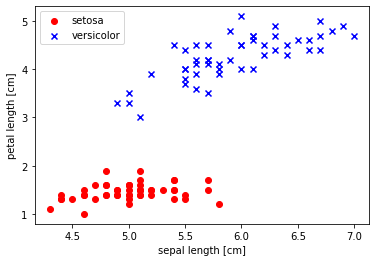

In [4]:
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

Based on the plot above, we can tell that the data is linearly separable, because we can draw a line between all the blue points and all the red points. This makes the data a good candidate for training on the Perceptron or another Linear Logistic Classifier. If I was using more than two features, this would be hard to visualize, but could be determined mathematically. If a couple red points were in the blue area or vice versa, we could account for that by accepting a certain level of inaccuracy. 

With these two lines, I create a Perceptron instance and fit the model on the training data:

In [5]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)

Now I can plot the errors, which we saved in an array with one element for the combined error after each iteration through the training data. I set up the Perceptron to run 10 times, so we have 10 error values. The plot shows us when the Perceptron converged, or settled on good values for the weights. The classifier converged after the 6th iteration, and it is now ready to accurately classify new data.

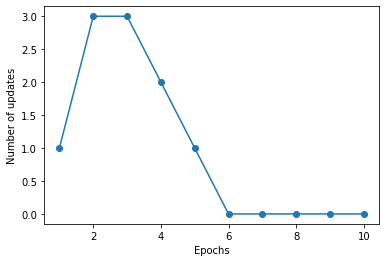

In [6]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

I used all the data on setosa and versicolor species to train, we we need to generate some new data using the min and max values for sepal length and petal length. The code in the 'plot decision surface' section below does this, and then passes the fabricated data to the predict method. This is done inside a utility function so we can generate the nice plot below.

In [7]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor='black')

Now we use the utility function to draw the plot, which shows the decision boundry the Perceptron identified and the decision regions - Or the points (sepal length, petal length) for which it would guess setosa vs versicolor. We'd do the same thing with more features, it would just be difficult to visualize.

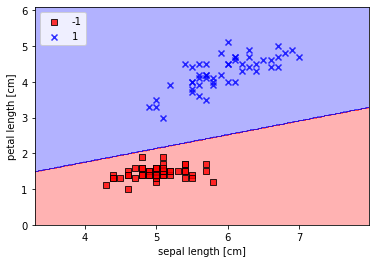

In [8]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

# Adaline Implementation

Adaline (Adaptive Linear Neurons) implements a Linear Logistic Classifier. Instead of using a step function (either -1 or 1) to update the weights, as I did in the Perceptron algorithm, Adaline uses a smooth curve which only reaches exactly -1 or 1 in the infinite limit. The function that produces the curve is the linear basis function that acts on the linear model (w^t)x + w_0. The simplest linear basis function is the identity function, which I will use in this implementation. 

To implement Adaline, all we need to do is update the fit method of Perceptron so that the weights are updated by minimizing the cost function, in this case Sum of Squares Error, via gradient descent. The gradient descent algorithm involves finding the global minimum. We choose an initial x, find f'(x), and then choose a new x by moving a certain amount (the step size) in the direction given by f'(x). Here, we start with every x, find y - f(x) or target - guess, and use this error to determine the direction in which we should move. We move by updating the parameters on the x values.

In [9]:
class AdalineGD(object):
    # Information flow: Features from input, net input (calculating f(x)), activation (apply basis func?), output (guess)
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size= 1 + X.shape[1])
        
        self.cost_ = []
        
        # Calculate the net input and gradient based on the whole X dataset at once n_iter times
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input) # guess for all X
            errors = (y - output)
            
            # Calculates the gradient based on whole dataset X at once
            # X.T.dot(errors): 2 X 100 dot 100 X 1 matrices makes 2 X 1
            self.w_[1:] += self.eta * X.T.dot(errors) #has three rows: the bias unit 0 and one for each feature
            self.w_[0] += self.eta * errors.sum()
            
            # Cost is SSE = SIGMA((y - output)^2)
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
            
        return self
            
    
    # Calculates y = x0w0 + x1w1 + ... + xmwm using current weights
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    # Identity function here, but will have effect on future models
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1 ,-1)

Questions:
1. Why do we divide sum of squares by 2?
2. Why do we add the total errors to the bias unit?

Eta (the learning rate or step size) and the number of iterations are hyperparameters - We need to tune these to get the optimal learning algorithm. I'll cover methods for finding optimal values for these parameters later, but we can get a feel for them by trying a couple things. 

The below code trains our model with the default parameters of eta = .01 and n_iter = 50. It doesn't work because .01 is too large a step size - The model overshoots the global minimum and the error actually gets larger with each iteration. This is hard to see if we plot the actual error, because the error values are very small and then increase dramatically at the end, so I took the log of the error. 

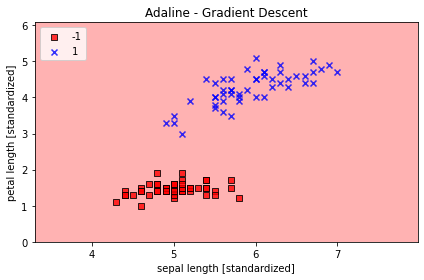

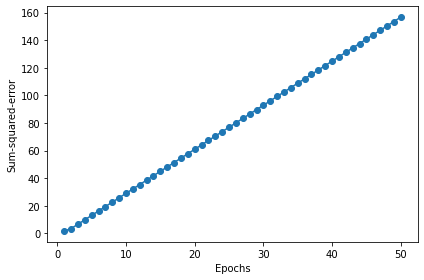

In [10]:
ada = AdalineGD()
ada.fit(X, y)

plot_decision_regions(X, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), np.log10(ada.cost_), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

Here it is with a step size of .001. This also fails because the model overshoots the global minimum, but if you notice the y-axis of the SSE vs Epochs graph, the error grows more slowly. This is expected, since a smaller step size means the model will move more slowly in the direction defined by error = y - output.

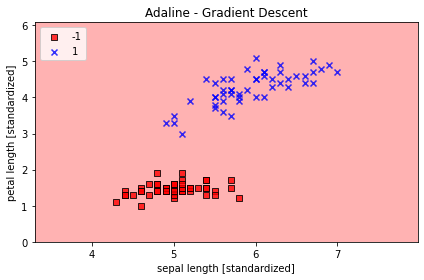

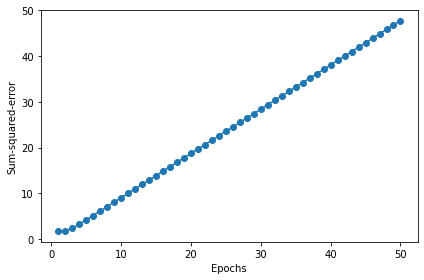

In [11]:
ada = AdalineGD(eta = .001)
ada.fit(X, y)

plot_decision_regions(X, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), np.log10(ada.cost_), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

Here you can see the model works with a step size of .0001, but it still doesn't really converge even after 50 iterations, because with such a small step size it moves very slowly in the direction of minimizing error.

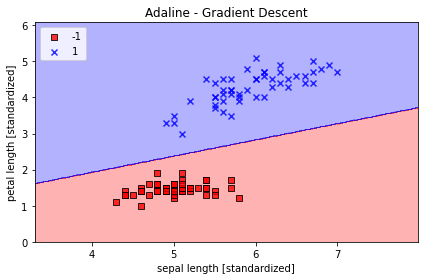

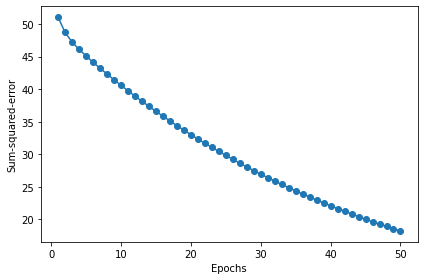

In [12]:
ada = AdalineGD(eta = .0001)
ada.fit(X, y)

plot_decision_regions(X, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

## Standardization

We need a way to get the model to converge more clearly and in less iterations. Standardization, a feature scaling technique, can do this by giving the data the properties of the normal distribution (zero mean and standard deviation of 1). To standardize, we subtract the actual mean from each value in X and divide by the actual standard distribution. After standardizing, adaline converges in only 15 epochs with a step size of .01 instead of .0001.

In [13]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

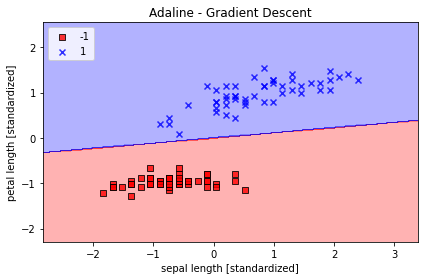

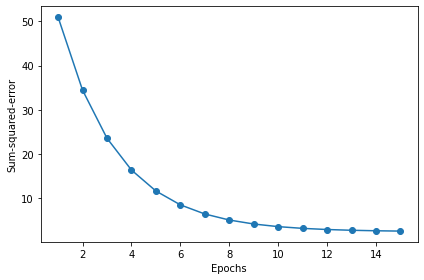

In [14]:
ada_std = AdalineGD(n_iter = 15)
ada_std.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_std)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_std.cost_) + 1), ada_std.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()